In [24]:
import torch
import math
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torch import Tensor
from torch import nn
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
else:
    device = torch.device('cpu')
    print(device)


cuda


In [25]:
#Generating pairs of 14x14
N=1000
(train_input,train_target,train_classes, \
 test_input,test_target,test_classes) = prologue.generate_pair_sets(N)

train_input = train_input.to(device)
test_input = test_input.to(device)
train_target = train_target.to(device)
test_target = test_target.to(device)


In [26]:
def norm_(train_input,test_input):
    """Function to normalize the input"""
    mu, std = train_input.mean(), train_input.std()
    train_inputOut = train_input.sub_(mu).div_(std)
    test_inputOut = test_input.sub_(mu).div_(std)
    return train_inputOut, test_inputOut
train_input,test_input = norm_(train_input,test_input);
print(train_input.device)


cuda:0


#### trainmodel and runnets are here


In [27]:
def train_model(model, train_input, train_target, nb_epochs=50, 
                eta=9e-2, mini_batch_size=50,printTrain = False, graphLoss = False):
    """Trains the model, using CrossEntropyLoss and SGD 
    Model : Architecture to be tested, pytorch.nn.Module
    Train_input : Input tensors Nx2x14x14, N = 1000
    Train_target : Target labels, N, classes = 0 or 1
    Nb_epochs : nb of epochs to train over
    eta : Learning rate
    mini_batch_size : Size of minibatch to be processed"""
    model.train(True)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    criterion.to(device)
    optimizer = optim.SGD(model.parameters(),lr=eta)
    losses = []
    
    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):    
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            losses.append(loss)
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if printTrain : 
            print("Epoch : {} :: Train error : {}/{}, {:0f}%".format(e,
            compute_nb_errors(model,train_input,train_target,mini_batch_size),train_target.size(0),
            (100*compute_nb_errors(model,train_input,train_target,mini_batch_size)/train_target.size(0))))
    if graphLoss : 
        plt.plot(losses)
        plt.ylabel('loss')
#--------------------------------------------------------------------------------------------------------#
def compute_nb_errors(model,data_input,data_target,mini_batch_size):
    """std from the séries"""
    nb_errors = 0;
    model.to(device)
    data_input, data_target = data_input.to(device),data_target.to(device)
    for b in range(0,data_input.size(0),mini_batch_size):
        output = model(data_input.narrow(0,b,mini_batch_size))
        _, predicted_classes = torch.max(output, 1)
        for k in range(mini_batch_size):
            if data_target[b+k]!=predicted_classes[k]:
                nb_errors += 1
    
    return nb_errors
#--------------------------------------------------------------------------------------------------------#
def run_net(model,train_input,train_target,
            test_input, test_target,
            nb_epochs = 50,eta=9e-2,mini_batch_size=50,
            printTrain = False,graphLoss = False):
    """"""
    model.to(device)
    print("Model tested : {}".format(str(model)[:str(model).find('(')]))
    print("""Using {} epochs, lr = {:.04f},Mini batch size = {}""".format(nb_epochs,
                                                                          eta,mini_batch_size))
    train_model(model, train_input, train_target,
                nb_epochs, eta, mini_batch_size,printTrain,graphLoss)
    model.train(False)
    train_error = compute_nb_errors(model, train_input, train_target,mini_batch_size) / train_input.size(0) * 100
    test_error = compute_nb_errors(model, test_input, test_target,mini_batch_size) / test_input.size(0) * 100
    print('train_error {:.02f}% test_error {:.02f}% \n'.format(
                train_error,
                test_error
            )
        )
    return float(test_error)

#### Weight sharing


In [ ]:
##Conv layers, based on the filter size and layer sizes tested in explorationLeNetDual
# must take 1x14x14 (so the same layers is used on both images)
# Separated the modules because I couldn't figure out how to make a single net work...
# will maybe merge into a single net later.
class convlayer(nn.Module):
    def __init__(self):
        super(convlayer, self).__init__()
        #self.conv1 : takes 1x14x14, gives 32x12x12, then maxpool(k=2) -> 32x6x6
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        #self.conv2 : takes 32x6x6, gives 64x4x4, then maxpool(k=2) -> outputs 64x2x2 to the fc layers
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2,stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2,stride=2))
        return x
#fc layers, adding a supp layer that has output dim 10 (instead of 2)
#in order to maybe calculate an aux loss on this output to have classification?
class shared_fclayer(nn.Module):
    def __init__(self):
        super(shared_fclayer,self).__init__()
        #gets in 64x2x2, convers to 1x250
        self.fc1 = nn.Linear(2*2*64,250)
        self.bn1 = nn.BatchNorm1d(250)
        #second layer : 250 to 100
        self.fc2 = nn.Linear(250,100)  
        self.bn2 = nn.BatchNorm1d(100)
        #outputs dim 10 so we can test the aux loss for classifying numbers
        #use softmax on fc3?
        self.fc3 = nn.Linear(100,10)
        self.dropout = nn.Dropout(0.25)
    def forward(self,x):
        x = self.dropout(self.bn1(F.relu(self.fc1(x.view(-1,2*2*64)))))
        x = self.dropout(self.bn2(F.relu(self.fc2(x))))
        x = F.relu(self.fc3(x))
        return x
#extra final layer, not shared
class final_predictionlayer(nn.Module):
    #this final layer should take 2*10 (one for each image) and output 2 
    def __init__(self):
        super(final_predictionlayer,self).__init__()
        self.final = nn.Linear(20,2)
    def forward(self,x):
        x = self.final(x)
        return x
    
class total_net(nn.Module):
    def __init__(self):
        super(total_net,self).__init__()
        self.convlayer = convlayer()
        self.fclayer = shared_fclayer()
        self.final = final_predictionlayer()
    def forward(self,x):
        tmp1 = x.narrow(1,0,1) #viewing only one image
        tmp2 = x.narrow(1,1,1) #viewing only one image
        #applying the conv layers
        tmp1 = self.convlayer.forward(tmp1) 
        tmp2 = self.convlayer.forward(tmp2)
        #applying the fc layers
        tmp1 = self.fclayer(tmp1)
        tmp2 = self.fclayer(tmp2)
        #viewing and final prediction
        output = torch.cat((tmp1,tmp2),1)
        output.view(-1,20)
        x = F.softmax(self.final(output),dim=1)
        return x
               

`def run_net(model,train_input,train_target,
            test_input, test_target,
            nb_epochs = 50,eta=9e-2,mini_batch_size=50,
            printTrain = False,graphLoss = False):`

Using 25 epochs, lr = 0.1000,Mini batch size = 25
Epoch : 0 :: Train error : 220/1000, 21.500000%
Epoch : 1 :: Train error : 169/1000, 17.600000%
Epoch : 2 :: Train error : 139/1000, 14.500000%
Epoch : 3 :: Train error : 109/1000, 11.700000%
Epoch : 4 :: Train error : 103/1000, 9.000000%
Epoch : 5 :: Train error : 134/1000, 12.900000%
Epoch : 6 :: Train error : 89/1000, 9.000000%
Epoch : 7 :: Train error : 84/1000, 8.400000%
Epoch : 8 :: Train error : 55/1000, 6.400000%
Epoch : 9 :: Train error : 57/1000, 5.200000%
Epoch : 10 :: Train error : 59/1000, 4.700000%
Epoch : 11 :: Train error : 42/1000, 3.800000%
Epoch : 12 :: Train error : 69/1000, 6.600000%
Epoch : 13 :: Train error : 35/1000, 3.000000%
Epoch : 14 :: Train error : 24/1000, 2.700000%
Epoch : 15 :: Train error : 51/1000, 4.300000%
Epoch : 16 :: Train error : 34/1000, 3.600000%
Epoch : 17 :: Train error : 16/1000, 1.700000%
Epoch : 18 :: Train error : 16/1000, 1.600000%
Epoch : 19 :: Train error : 14/1000, 1.400000%
Epoch : 2

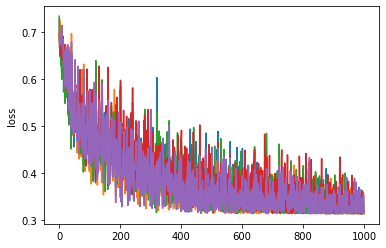

In [8]:
err = 0;
for n in range(5):
    err+= run_net(total_net(),train_input,train_target,
                 test_input,test_target,nb_epochs = 25, 
                  eta = 1e-1,mini_batch_size=25,printTrain=True,graphLoss=True)
    
print(err/5)

In [10]:
goodList = []
for e in [25,37,50]:
    for lr in [1e-1,7.5e-2,5e-2,3.3e-2]:
        for bn in [25,50,100]:
            err = 0.;
            for n in range(3):
                model = total_net()
                err+=run_net(model,train_input,train_target,
                             test_input,test_target,e,lr,bn)
            if err/3 <= 14:
                goodList.append([err/3,e,lr,bn])
print(goodList)

Using 25 epochs, lr = 0.1000,Mini batch size = 25
train_error 1.50% test_error 12.40% 

Using 25 epochs, lr = 0.1000,Mini batch size = 25
train_error 0.80% test_error 13.80% 

Using 25 epochs, lr = 0.1000,Mini batch size = 25
train_error 1.60% test_error 13.00% 

Using 25 epochs, lr = 0.1000,Mini batch size = 50
train_error 0.50% test_error 14.40% 

Using 25 epochs, lr = 0.1000,Mini batch size = 50
train_error 1.00% test_error 16.50% 

Using 25 epochs, lr = 0.1000,Mini batch size = 50
train_error 0.40% test_error 15.30% 

Using 25 epochs, lr = 0.1000,Mini batch size = 100
train_error 0.70% test_error 13.50% 

Using 25 epochs, lr = 0.1000,Mini batch size = 100
train_error 0.50% test_error 14.70% 

Using 25 epochs, lr = 0.1000,Mini batch size = 100
train_error 1.20% test_error 11.70% 

Using 25 epochs, lr = 0.0750,Mini batch size = 25
train_error 1.10% test_error 12.00% 

Using 25 epochs, lr = 0.0750,Mini batch size = 25
train_error 0.90% test_error 14.50% 

Using 25 epochs, lr = 0.0750,

#### testing various layer sizes and dropouts
`total_net_test(l1,l2,drop)`

In [39]:
#big brain LOOPS
class shared_fclayer_test(nn.Module):
    def __init__(self,l1,l2,drop):
        super(shared_fclayer_test,self).__init__()
        #gets in 64x2x2, convers to 1x250
        self.fc1 = nn.Linear(2*2*64,l1)
        self.bn1 = nn.BatchNorm1d(l1)
        #second layer : 250 to 100
        self.fc2 = nn.Linear(l1,l2)  
        self.bn2 = nn.BatchNorm1d(l2)
        #outputs dim 10 so we can test the aux loss for classifying numbers
        #use softmax on fc3?
        self.fc3 = nn.Linear(l2,10)
        self.dropout = nn.Dropout(drop)
    def forward(self,x):
        x = self.dropout(self.bn1(F.relu(self.fc1(x.view(-1,2*2*64)))))
        x = self.dropout(self.bn2(F.relu(self.fc2(x))))
        x = F.relu(self.fc3(x))
        return x

class total_net_test(nn.Module):
    def __init__(self,l1,l2,drop):
        super(total_net_test,self).__init__()
        self.convlayer = convlayer()
        self.fclayer = shared_fclayer_test(l1,l2,drop)
        self.final = final_predictionlayer()
    def forward(self,x):
        tmp1 = x.narrow(1,0,1) #viewing only one image
        tmp2 = x.narrow(1,1,1) #viewing only one image
        #applying the conv layers
        tmp1 = self.convlayer.forward(tmp1) 
        tmp2 = self.convlayer.forward(tmp2)
        #applying the fc layers
        tmp1 = self.fclayer(tmp1)
        tmp2 = self.fclayer(tmp2)
        #viewing and final prediction
        output = torch.cat((tmp1,tmp2),1)
        output.view(-1,20)
        x = F.softmax(self.final(output),dim=1)
        return x

class total_net_testrelu(nn.Module):
    def __init__(self,l1,l2,drop):
        super(total_net_testrelu,self).__init__()
        self.convlayer = convlayer()
        self.fclayer = shared_fclayer_test(l1,l2,drop)
        self.final = final_predictionlayer()
    def forward(self,x):
        tmp1 = x.narrow(1,0,1) #viewing only one image
        tmp2 = x.narrow(1,1,1) #viewing only one image
        #applying the conv layers
        tmp1 = self.convlayer.forward(tmp1) 
        tmp2 = self.convlayer.forward(tmp2)
        #applying the fc layers
        tmp1 = self.fclayer(tmp1)
        tmp2 = self.fclayer(tmp2)
        #viewing and final prediction
        output = torch.cat((tmp1,tmp2),1)
        output.view(-1,20)
        x = F.relu(self.final(output))
        return x

class total_net_testnthg(nn.Module):
    def __init__(self,l1,l2,drop):
        super(total_net_testnthg,self).__init__()
        self.convlayer = convlayer()
        self.fclayer = shared_fclayer_test(l1,l2,drop)
        self.final = final_predictionlayer()
    def forward(self,x):
        tmp1 = x.narrow(1,0,1) #viewing only one image
        tmp2 = x.narrow(1,1,1) #viewing only one image
        #applying the conv layers
        tmp1 = self.convlayer.forward(tmp1) 
        tmp2 = self.convlayer.forward(tmp2)
        #applying the fc layers
        tmp1 = self.fclayer(tmp1)
        tmp2 = self.fclayer(tmp2)
        #viewing and final prediction
        output = torch.cat((tmp1,tmp2),1)
        output.view(-1,20)
        x = self.final(output)
        return x
                       

In [ ]:
goodLayers = []
nb_epochs = 50
eta = 9e-2
bn = 25
for l1 in [100,150,200,264,350]:
    for l2 in [30,50,70,100,150,200]:
        for drop in [0.1,0.25,0.4]:
            err = 0;
            print("l1 = {}, l2 ={}, drop = {}".format(l1,l2,drop))
            for n in range(3):
                model = total_net_test(l1,l2,drop)
                err += run_net(model,train_input,train_target,
                               test_input,test_target,nb_epochs,eta,bn)
                
            if err/3 <= 14:
                goodList.append([err/3,l1,l2,drop])
print(goodList)

l1 = 100, l2 =30, drop = 0.1
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.40% test_error 16.40% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.20% test_error 14.60% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.10% test_error 13.50% 

l1 = 100, l2 =30, drop = 0.25
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.60% test_error 14.30% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.70% test_error 14.30% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 1.00% test_error 13.50% 

l1 = 100, l2 =30, drop = 0.4
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.60% test_error 15.50% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.80% test_error 13.30% 

Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 2.00% test_error 16.80% 

l1 = 100, l2 =50, drop = 0.1
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.50% test_error 13.40% 

Usi

In [40]:
print(goodList)

[[13.066666666666668, 25, 0.1, 25], [13.299999999999999, 25, 0.1, 100], [13.866666666666667, 25, 0.075, 25], [13.6, 25, 0.05, 100], [13.799999999999999, 25, 0.033, 100], [12.733333333333334, 37, 0.1, 25], [13.366666666666665, 37, 0.075, 25], [13.733333333333334, 37, 0.033, 25], [12.233333333333334, 50, 0.1, 25], [13.466666666666667, 50, 0.1, 50], [12.866666666666667, 50, 0.05, 25], [14.0, 100, 70, 0.1], [13.799999999999999, 100, 70, 0.25], [13.700000000000001, 100, 70, 0.4], [13.666666666666666, 100, 100, 0.1], [13.700000000000001, 100, 100, 0.25], [13.266666666666667, 100, 150, 0.1], [13.866666666666667, 100, 150, 0.25], [13.666666666666666, 100, 200, 0.1], [13.933333333333335, 100, 200, 0.4], [13.866666666666667, 150, 30, 0.25], [13.433333333333335, 150, 50, 0.1], [13.700000000000001, 150, 70, 0.1], [12.866666666666667, 150, 70, 0.25], [12.433333333333332, 150, 100, 0.1], [13.333333333333334, 150, 100, 0.25], [13.700000000000001, 150, 100, 0.4], [13.133333333333335, 150, 150, 0.1], [

In [38]:
#With the best layer sizes, try diff activations
nb_epochs = 50
eta = 9e-2
bn = 25
l1,l2,drop = 264,100,0.25
for model in [total_net_testnthg(l1,l2,drop),total_net_testrelu(l1,l2,drop),total_net_test(l1,l2,drop)]:
    err =0;
    for n in range(3):
        err+=run_net(model,train_input,train_target,test_input,test_target,
               nb_epochs,eta,bn)
    print(model)
    print(err/3)
    

Model tested : total_net_testnthg
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.80% test_error 13.20% 

Model tested : total_net_testnthg
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.70% test_error 14.50% 

Model tested : total_net_testnthg
Using 50 epochs, lr = 0.0900,Mini batch size = 25
train_error 0.70% test_error 15.30% 

total_net_testnthg(
  (convlayer): convlayer(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (fclayer): shared_fclayer_test(
    (fc1): Linear(in_features=256, out_features=264, bias=True)
    (bn1): BatchNorm1d(264, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=264, out_features=100, bias=True)
    (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc3): Linear(in_features=100, out_features=10, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
